# Case Study : Credit Card Approval Prediction (Developing a Machine Learning Model for Credit Scoring)

   
## Background:

Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.
 
Generally speaking, credit score cards are based on historical data. Once encountering large economic fluctuations. Past models may lose their original predictive power. Logistic model is a common method for credit scoring. Because Logistic is suitable for binary classification tasks and can calculate the coefficients of each feature. In order to facilitate understanding and operation, the score card will multiply the logistic regression coefficient by a certain value (such as 100) and round it.   

## Detail Data Description : 

### 1. Data Sheet1: application_record.csv

ID                  : Client number
CODE_GENDER         : Gender
FLAG_OWN_CAR        : Is there a car
FLAG_OWN_REALTY     : Is there a property
CNT_CHILDREN        : Number of children
AMT_INCOME_TOTAL    : Annual income
NAME_INCOME_TYPE    : Income category
NAME_EDUCATION_TYPE : Education level
NAME_FAMILY_STATUS  : Marital status
NAME_HOUSING_TYPE   : Way of living
DAYS_BIRTH          : Birthday (Count backwards from current day (0), -1 means yesterday)
DAYS_EMPLOYED       : Start date of employment (Count backwards from current day(0). If positive, it means the person                                 currently unemployed.)
FLAG_MOBIL          : Is there a mobile phone
FLAG_WORK_PHONE     : Is there a work phone
FLAG_PHONE          : Is there a phone
FLAG_EMAIL          : Is there an email
OCCUPATION_TYPE     : Occupation
CNT_FAM_MEMBERS     : Family size

### 2. Data Sheet2: credit_record.csv

ID                  : Client number
MONTHS_BALANCE      : Record month (The month of the extracted data is the starting point, backwards, 0 is the current month,                         -1 is the previous month, and so on)
STATUS              : Status (0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4:                             120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month                           X: No loan for the month)

### Objective:

The goal is to build a machine learning model to predict whether a credit card applicant is a 'good' or 'bad' client. This involves:

1. Exploratory data analysis (EDA) to understand and preprocess the data
2. Developing a logistic regression model as a baseline.
3. Implementing advanced machine learning models.
4. Comparing their performance and interpretability.
5. Ensuring the model can adapt to economic fluctuations.


#### Define Hypotheses:

**Null Hypothesis (H0)**: The credit card applicant is a 'good' client. This means that, based on the available data and the trained model, there is no significant evidence to suggest that the applicant will default.

**Alternative Hypothesis (H1)**: The credit card applicant is a 'bad' client. This means that there is significant evidence, based on the model, to suggest that the applicant will default.

In [1]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [160]:
pip install imbalanced-learn

In [164]:
pip install --upgrade imbalanced-learn scikit-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/5a/fa/267de06c95210580f4b82b45cec1ce1e9ce1f21a01a684367db89e7da70d/imbalanced_learn-0.12.3-py3-none-any.whl.metadata
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.12.3-py3-none-any.whl (258 kB)
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1
Note: you may need to restart the kernel to use updated packages.


In [647]:
# loading libraries

# general libraries
import pandas as pd
import os
import numpy as np

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime

# stats libraries
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report, f1_score, confusion_matrix, precision_score, recall_score
from xgboost import XGBClassifier

### Import Data from Application Record & Credit Record

In [648]:
df_application_record = pd.read_csv('C:\Personal\Imperial College\Cerificate in Data Analytics\Capston Project\Data Set\Credit Card Approval Predictions/application_record.csv')
df_credit_record = pd.read_csv('C:\Personal\Imperial College\Cerificate in Data Analytics\Capston Project\Data Set\Credit Card Approval Predictions/credit_record.csv')


#### EDA & Data Check

In [649]:
# Identify the total number of rows and columns from the imported sheets.

print('Total number of rows and columns of credit card application', df_application_record.shape)
print('Total number of rows and columns of credit score', df_credit_record.shape)

Total number of rows and columns of credit card application (438557, 18)
Total number of rows and columns of credit score (1048575, 3)


In [650]:
type(df_application_record)
type(df_credit_record)

pandas.core.frame.DataFrame

In [651]:
df_application_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [652]:
df_credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [653]:
# Identify the column Names

df_application_record.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],
      dtype='object')

In [654]:
df_credit_record.columns

Index(['ID', 'MONTHS_BALANCE', 'STATUS'], dtype='object')

In [655]:
df_application_record.index

RangeIndex(start=0, stop=438557, step=1)

In [656]:
df_credit_record.index

RangeIndex(start=0, stop=1048575, step=1)

In [657]:
# Identify the detail information on data set

df_application_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [658]:
df_credit_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [659]:
df_application_record.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

In [660]:
# Idenitfy the duplication

df_application_record.duplicated().sum()

0

In [661]:
df_credit_record.duplicated().sum()

0

In [662]:
# Identify the null values

df_application_record.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [663]:
df_application_record = df_application_record.drop(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 
                                                    'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL'], axis=1)

In [664]:
df_credit_record.nunique()

ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

In [665]:
df_credit_record.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [666]:
df_credit_record_clean = df_credit_record.groupby(["ID", "STATUS"], as_index=False).agg(status_count=("MONTHS_BALANCE", "count"))
df_credit_record_clean

,ID,STATUS,status_count
0,5001711,0,3
1,5001711,X,1
2,5001712,0,10
3,5001712,C,9
4,5001713,X,22
...,...,...,...
94138,5150483,X,18
94139,5150484,0,12
94140,5150484,C,1
94141,5150485,0,2


In [667]:
df_credit_record_clean['ranked_status'] = df_credit_record_clean.groupby("ID")["status_count"].transform(lambda x: x.rank(method='first', ascending=False))

In [668]:
df_credit_record_clean

,ID,STATUS,status_count,ranked_status
0,5001711,0,3,1.0
1,5001711,X,1,2.0
2,5001712,0,10,1.0
3,5001712,C,9,2.0
4,5001713,X,22,1.0
...,...,...,...,...
94138,5150483,X,18,1.0
94139,5150484,0,12,1.0
94140,5150484,C,1,2.0
94141,5150485,0,2,1.0


In [669]:
df_credit_record_clean.query("ranked_status == 1")

,ID,STATUS,status_count,ranked_status
0,5001711,0,3,1.0
2,5001712,0,10,1.0
4,5001713,X,22,1.0
5,5001714,X,15,1.0
6,5001715,X,60,1.0
...,...,...,...,...
94136,5150482,0,12,1.0
94138,5150483,X,18,1.0
94139,5150484,0,12,1.0
94141,5150485,0,2,1.0


In [670]:
final_data = df_credit_record_clean.query("ranked_status == 1").drop(columns = ["status_count", "ranked_status"], axis = 1)
final_data.shape

(45985, 2)

In [671]:
# Merge both the data sets to proceed further data processing

df = pd.merge(df_application_record, final_data, on = 'ID', how = 'inner')


In [672]:
df

,ID,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,5008804,M,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,NaN,2.0,C
1,5008805,M,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,NaN,2.0,C
2,5008806,M,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,Security staff,2.0,X
3,5008808,F,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1.0,X
4,5008809,F,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1.0,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348,-2420,Managers,2.0,X
36453,5149834,F,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,Medicine staff,2.0,1
36454,5149838,F,0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387,-1325,Medicine staff,2.0,C
36455,5150049,F,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,Sales staff,2.0,0


In [673]:
print('Total number of rows and columns of credit card application', df_application_record.shape)
print('Total number of rows and columns of credit score', final_data.shape)
print('Total number of rows and columns of merged data set', df.shape)


Total number of rows and columns of credit card application (438557, 12)
Total number of rows and columns of credit score (45985, 2)
Total number of rows and columns of merged data set (36457, 13)


In [674]:
#merged_dataset = pd.DataFrame(df)

In [675]:
#file_path = r'C:\Personal\Imperial College\Cerificate in Data Analytics\Capston Project\Data Set\Credit Card Approval Predictions\merged_Credit_record_dataset.xlsx'
#print(file_path)

In [676]:
# directory = os.path.dirname(file_path)
# if not os.path.exists(directory):
#     os.makedirs(directory)
#     print(f"The directory {directory} was created.")

# # Save the DataFrame to an Excel file
# merged_dataset.to_excel(file_path, index=False)
# print(f'DataFrame is saved to {file_path}')

In [677]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   CNT_CHILDREN         36457 non-null  int64  
 3   AMT_INCOME_TOTAL     36457 non-null  float64
 4   NAME_INCOME_TYPE     36457 non-null  object 
 5   NAME_EDUCATION_TYPE  36457 non-null  object 
 6   NAME_FAMILY_STATUS   36457 non-null  object 
 7   NAME_HOUSING_TYPE    36457 non-null  object 
 8   DAYS_BIRTH           36457 non-null  int64  
 9   DAYS_EMPLOYED        36457 non-null  int64  
 10  OCCUPATION_TYPE      25134 non-null  object 
 11  CNT_FAM_MEMBERS      36457 non-null  float64
 12  STATUS               36457 non-null  object 
dtypes: float64(2), int64(4), object(7)
memory usage: 3.9+ MB


In [678]:
df.nunique()

ID                     36457
CODE_GENDER                2
CNT_CHILDREN               9
AMT_INCOME_TOTAL         265
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH              7183
DAYS_EMPLOYED           3640
OCCUPATION_TYPE           18
CNT_FAM_MEMBERS           10
STATUS                     6
dtype: int64

In [679]:
df.duplicated().sum()

0

In [680]:
df.isna().sum()

ID                         0
CODE_GENDER                0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
STATUS                     0
dtype: int64

In [681]:
df["NAME_INCOME_TYPE"].value_counts()

Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64

**Unique Values of each column and Counts

In [682]:
df["NAME_EDUCATION_TYPE"].value_counts()

Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: NAME_EDUCATION_TYPE, dtype: int64

In [683]:
df["NAME_FAMILY_STATUS"].value_counts()

Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: NAME_FAMILY_STATUS, dtype: int64

In [684]:
df["NAME_HOUSING_TYPE"].value_counts()

House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: NAME_HOUSING_TYPE, dtype: int64

In [685]:
df["OCCUPATION_TYPE"].value_counts()

Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: OCCUPATION_TYPE, dtype: int64

**Observation:

1. There are only one column in our datafrme which has null values.
2. This column is OCCUPATION_TYPE and it has 240048 missing values and it has percentage of 30.86% missing values
 

In [686]:
#df.drop('OCCUPATION_TYPE', axis=1, inplace=True)

In [687]:
df.columns

Index(['ID', 'CODE_GENDER', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'STATUS'],
      dtype='object')

In [688]:

df_copy = df.copy()

#df_copy.info()

In [689]:
#col_Exclude = 'ID'



In [690]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,2.198453
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.911686
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,2.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,2.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,3.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,20.000000


In [691]:
# ID is an Unique column which used for unique identification of the clients. 
# We don't required the statistical details for this column.


df_ID_Exclude = df_copy.drop(columns = 'ID')

df_ID_Exclude.describe().T.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
CNT_CHILDREN,36457.000000,0.430315,0.742367,0.000000,0.000000,0.000000,1.000000,19.000000
AMT_INCOME_TOTAL,36457.000000,186685.736662,101789.226482,27000.000000,121500.000000,157500.000000,225000.000000,1575000.000000
DAYS_BIRTH,36457.000000,-15975.173382,4200.549944,-25152.000000,-19438.000000,-15563.000000,-12462.000000,-7489.000000
DAYS_EMPLOYED,36457.000000,59262.935568,137651.334859,-15713.000000,-3153.000000,-1552.000000,-408.000000,365243.000000
CNT_FAM_MEMBERS,36457.000000,2.198453,0.911686,1.000000,2.000000,2.000000,3.000000,20.000000


In [692]:
df[df['DAYS_EMPLOYED']>= 0]['DAYS_EMPLOYED'].value_counts()

365243    6135
Name: DAYS_EMPLOYED, dtype: int64

In [693]:
df['YEARS_AGE'] = round(-df['DAYS_BIRTH'] / 365.25)

In [694]:
df['YEARS_AGE']

0        33.0
1        33.0
2        59.0
3        52.0
4        52.0
         ... 
36452    47.0
36453    34.0
36454    34.0
36455    49.0
36456    25.0
Name: YEARS_AGE, Length: 36457, dtype: float64

In [695]:
df['YEARS_EMPLOYED'] = round(-df['DAYS_EMPLOYED'] / 365.25)
df.loc[df['YEARS_EMPLOYED'] < 0, 'YEARS_EMPLOYED'] = 0

In [696]:
df[df['YEARS_EMPLOYED']<=0]['YEARS_EMPLOYED'].value_counts()

0.0    7040
Name: YEARS_EMPLOYED, dtype: int64

In [697]:
df.drop(columns = ["DAYS_BIRTH", "DAYS_EMPLOYED"], inplace = True)

In [698]:
df.describe().T.style.format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
ID,36457.00,5078227.00,41875.24,5008804.00,5042028.00,5074614.00,5115396.00,5150487.00
CNT_CHILDREN,36457.00,0.43,0.74,0.00,0.00,0.00,1.00,19.00
AMT_INCOME_TOTAL,36457.00,186685.74,101789.23,27000.00,121500.00,157500.00,225000.00,1575000.00
CNT_FAM_MEMBERS,36457.00,2.20,0.91,1.00,2.00,2.00,3.00,20.00
YEARS_AGE,36457.00,43.75,11.51,21.00,34.00,43.00,53.00,69.00
YEARS_EMPLOYED,36457.00,6.04,6.49,0.00,1.00,4.00,9.00,43.00


In [699]:
df['LOAN_STATUS'] = df['STATUS'].map({'0' : '1st Month Overdue', '1' : '2nd Month Overdue', '2' : '3rd Month Overdue',
                                    '3' : '4th Month Overdue', '4' : '5th Month Overdue', '5' : 'Overdue / Bad Debts',
                                    'C' : 'Good', 'X': 'No Loan'})

CODE_GENDER                F       M
LOAN_STATUS                         
1st Month Overdue    11847.0  5675.0
2nd Month Overdue       44.0    37.0
3rd Month Overdue        NaN     2.0
Good                  8578.0  4229.0
No Loan               3935.0  2063.0
Overdue / Bad Debts     26.0    21.0


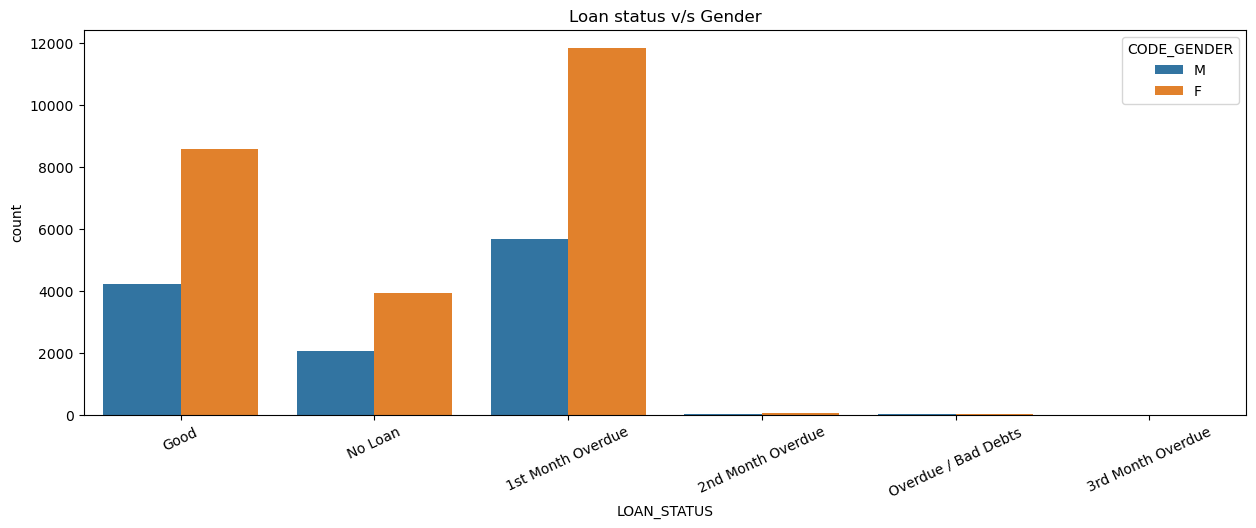

In [700]:
# checking the relationship between loan status and gender

LoanStatus_Gender = df.groupby('LOAN_STATUS')['CODE_GENDER'].value_counts().unstack()
print(LoanStatus_Gender)

# defining the figure size
plt.figure(figsize=(15, 5))

# plotting the countplot
sns.countplot(data=df, x=df['LOAN_STATUS'], hue=df['CODE_GENDER'])

# defining the tilte
plt.title('Loan status v/s Gender')
# rotating the x-axis labels
plt.xticks(rotation=25)
plt.show()

CODE_GENDER               F     M
NAME_INCOME_TYPE                 
Commercial associate   5533  2957
Pensioner              5244   908
State servant          2199   786
Student                  10     1
Working               11444  7375


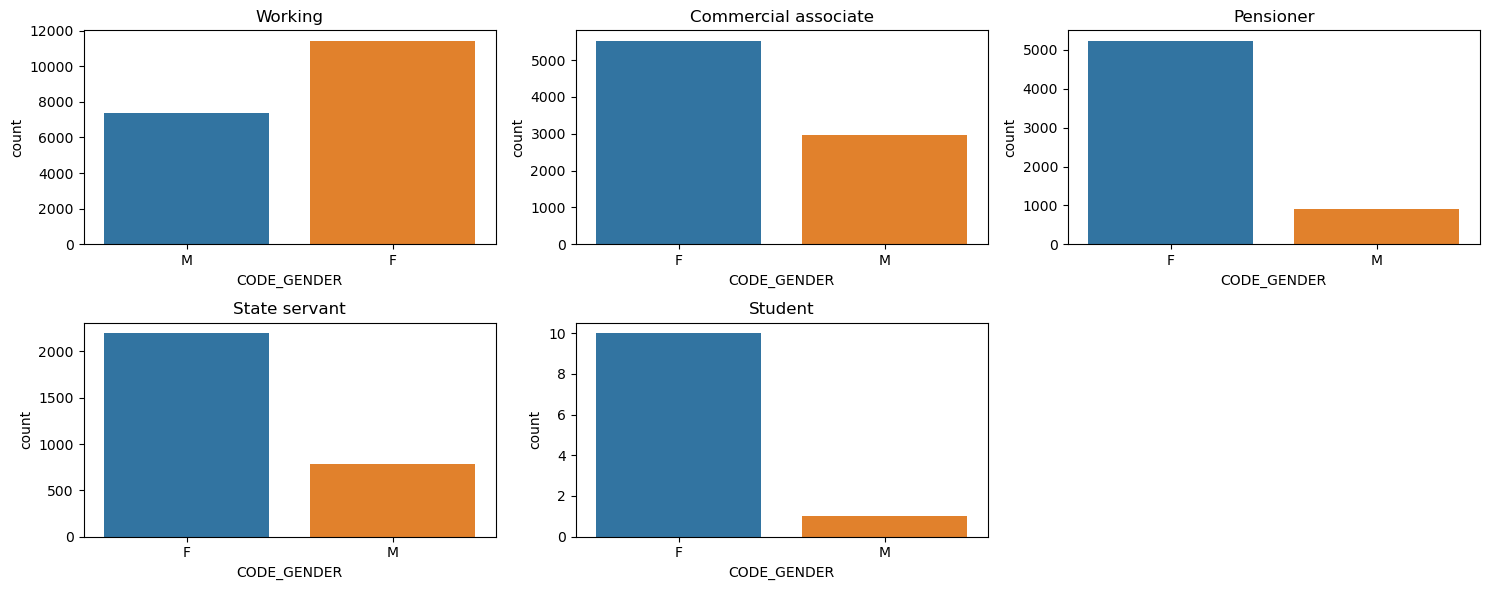

In [701]:
IncomeType_Gender = df.groupby('NAME_INCOME_TYPE')['CODE_GENDER'].value_counts().unstack()
print(IncomeType_Gender)


IncomeType_Count = df['NAME_INCOME_TYPE'].value_counts()

plt.figure(figsize=(15, 6))

# Plotting the countplot for each unique value of 'income_type'

for i in range(len(IncomeType_Count)):
    plt.subplot(2, 3, i+1)
    
    # Use the unique value of 'income_type' as the title
    plt.title(IncomeType_Count.index[i])
        
    sns.countplot(data = df[df['NAME_INCOME_TYPE'] == IncomeType_Count.index[i]], x = 'CODE_GENDER')
    #plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()


NAME_INCOME_TYPE     Commercial associate  Pensioner  State servant  Student  \
LOAN_STATUS                                                                    
1st Month Overdue                  4058.0     3041.0         1420.0      3.0   
2nd Month Overdue                    26.0       13.0            5.0      NaN   
3rd Month Overdue                     NaN        NaN            NaN      NaN   
Good                               2947.0     2139.0         1060.0      7.0   
No Loan                            1440.0      948.0          499.0      1.0   
Overdue / Bad Debts                  19.0       11.0            1.0      NaN   

NAME_INCOME_TYPE     Working  
LOAN_STATUS                   
1st Month Overdue     9000.0  
2nd Month Overdue       37.0  
3rd Month Overdue        2.0  
Good                  6654.0  
No Loan               3110.0  
Overdue / Bad Debts     16.0  


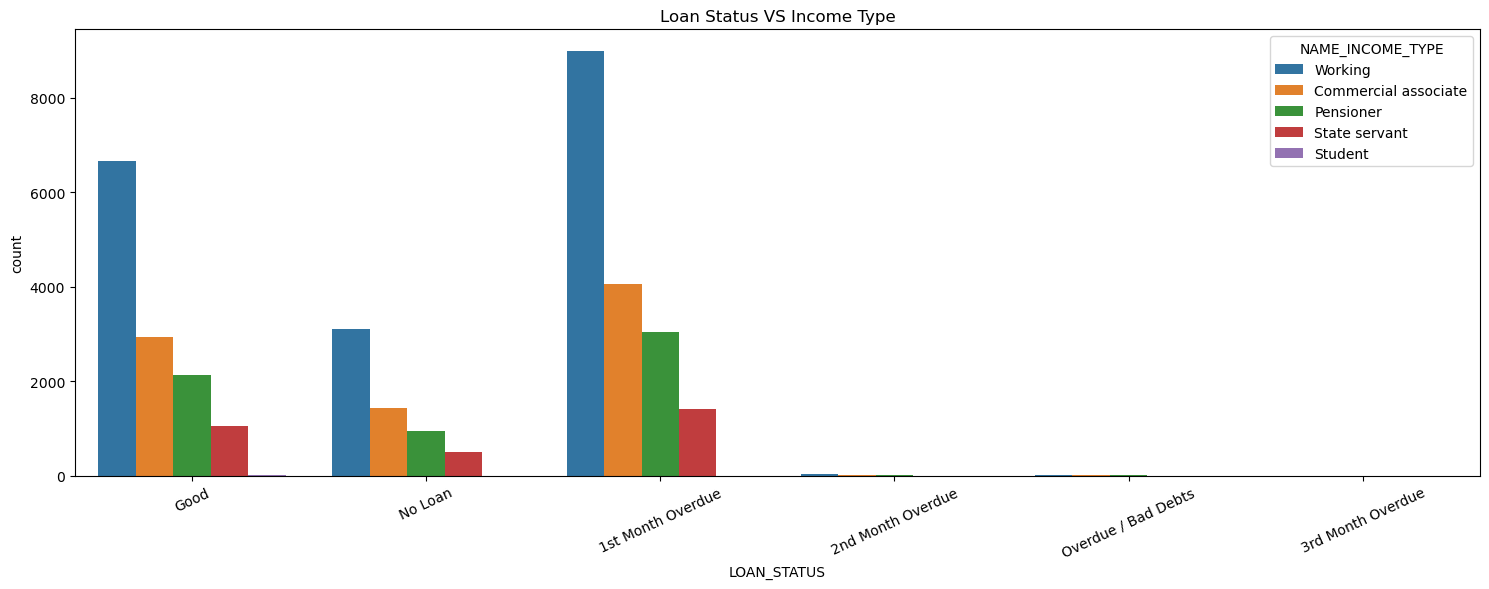

In [702]:
LoanStatus_IncomeType = df.groupby('LOAN_STATUS')['NAME_INCOME_TYPE'].value_counts().unstack()
print(LoanStatus_IncomeType)

plt.figure(figsize=(15, 6))

sns.countplot(data = df, x = df['LOAN_STATUS'], hue = df['NAME_INCOME_TYPE'] )
plt.title('Loan Status VS Income Type')

plt.xticks(rotation = 25)

plt.tight_layout()
plt.show()

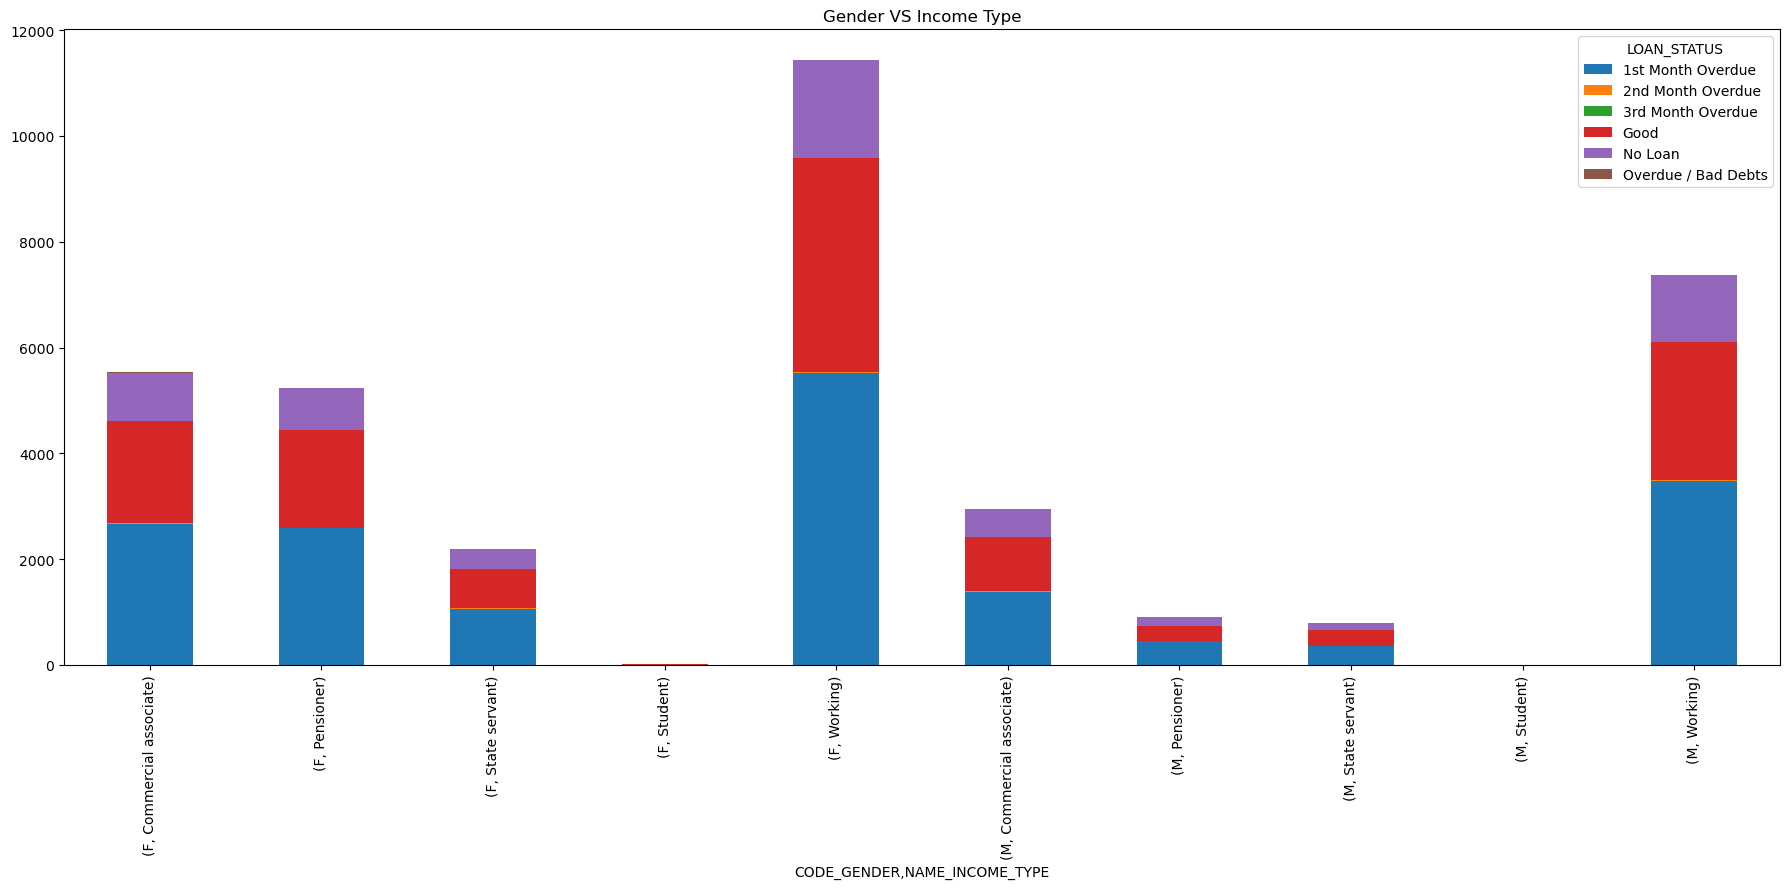

In [703]:
LoanStatus_IncomeType = df.groupby('CODE_GENDER')[['NAME_INCOME_TYPE', 'LOAN_STATUS']].value_counts().unstack()
#print(LoanStatus_IncomeType)

LoanStatus_IncomeType.plot(kind = 'bar', figsize=(18, 9), stacked = True)
plt.title('Gender VS Income Type')

#LoanStatus_IncomeType.plot(kind = 'area', figsize=(18, 9))

#plt.xticks(rotation = 25)

plt.tight_layout()
plt.show()

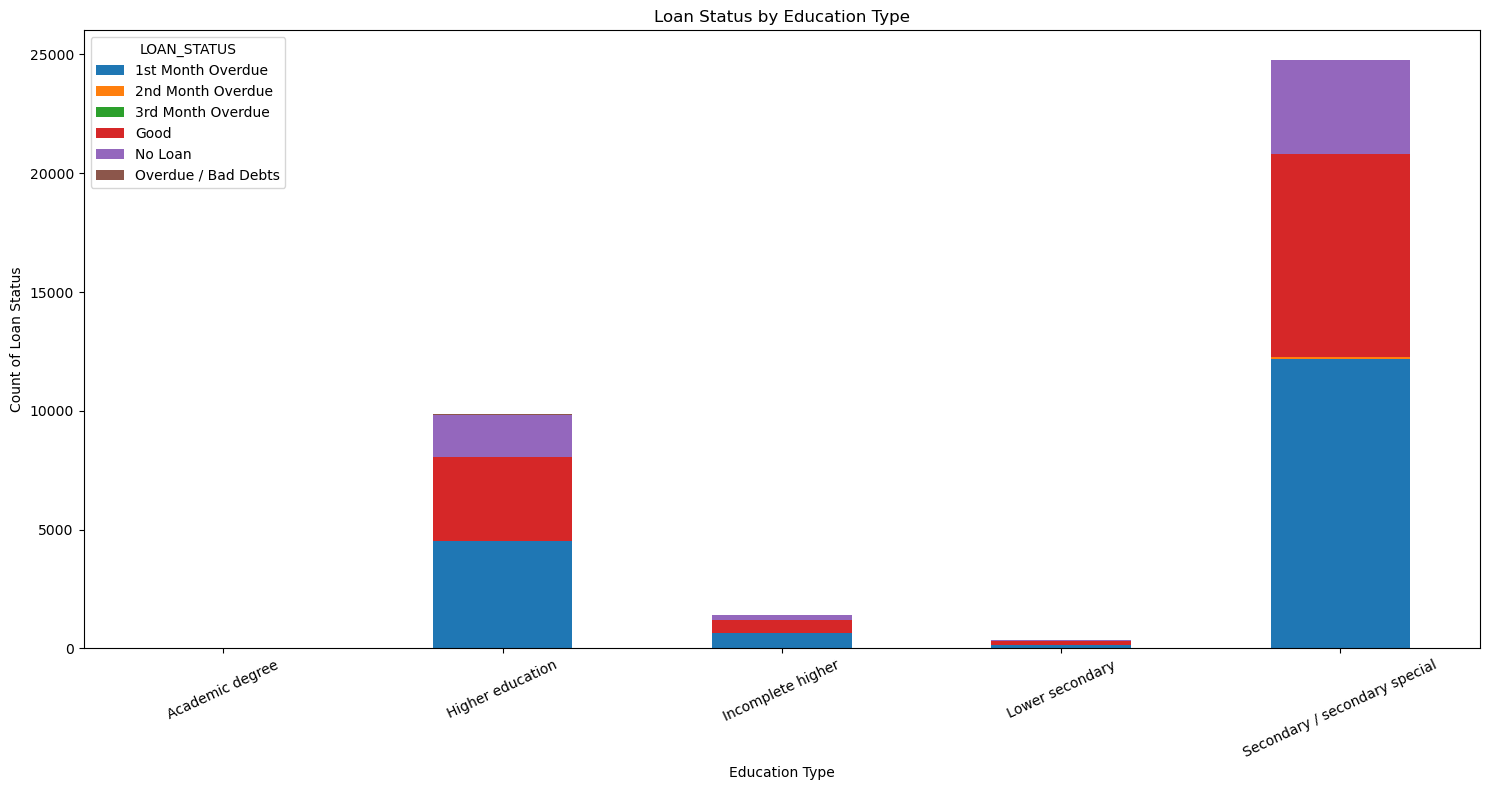

In [704]:
# Calculate the counts of LOAN_STATUS by NAME_EDUCATION_TYPE
education_Loanstatus = df.groupby('NAME_EDUCATION_TYPE')['LOAN_STATUS'].value_counts().unstack().fillna(0)

# Plot the data using a bar plot
education_Loanstatus.plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('Loan Status by Education Type')
plt.xlabel('Education Type')
plt.ylabel('Count of Loan Status')

plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

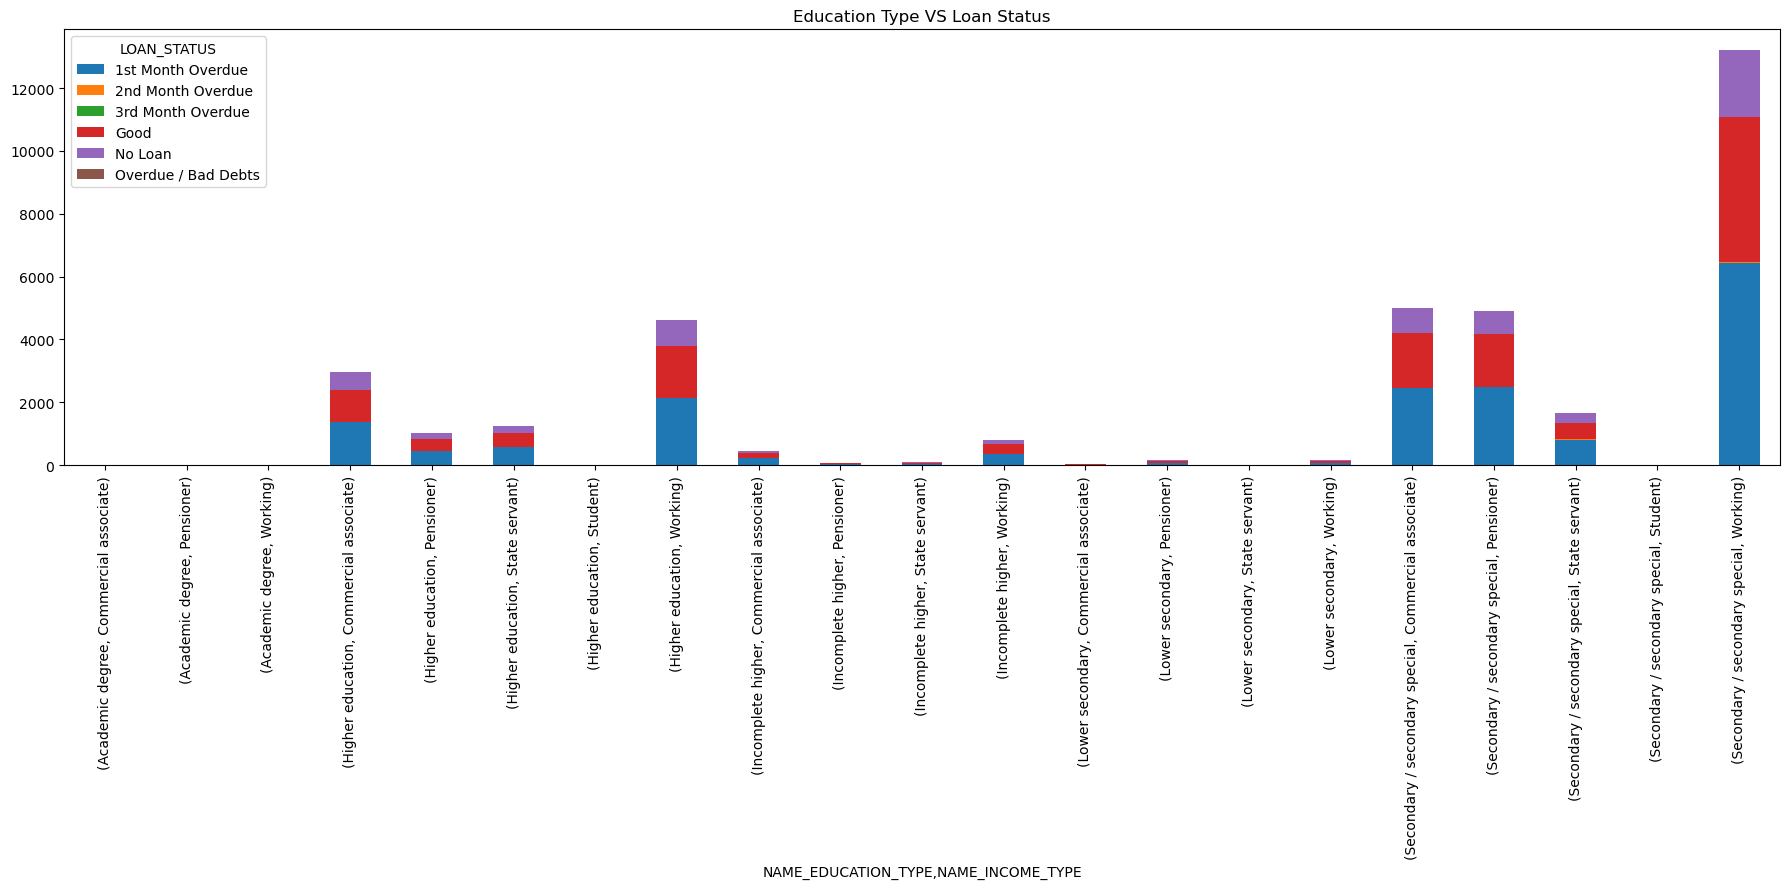

In [705]:
EducationType_LoanStatus = df.groupby(['NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE'])['LOAN_STATUS'].value_counts().unstack()
#print(EducationType_LoanStatus)

EducationType_LoanStatus.plot(kind = 'bar', figsize=(18, 9), stacked = True)

#sns.countplot(data = df, x = df['NAME_EDUCATION_TYPE'], hue = df['LOAN_STATUS'] )
plt.title('Education Type VS Loan Status')

#plt.xticks(rotation = 25)

plt.tight_layout()
plt.show()

NAME_HOUSING_TYPE    Co-op apartment  House / apartment  Municipal apartment  \
LOAN_STATUS                                                                    
1st Month Overdue               65.0            15667.0                538.0   
2nd Month Overdue                NaN               74.0                  2.0   
3rd Month Overdue                1.0                1.0                  NaN   
Good                            50.0            11467.0                379.0   
No Loan                         52.0             5298.0                208.0   
Overdue / Bad Debts              NaN               41.0                  1.0   

NAME_HOUSING_TYPE    Office apartment  Rented apartment  With parents  
LOAN_STATUS                                                            
1st Month Overdue               120.0             293.0         839.0  
2nd Month Overdue                 3.0               NaN           2.0  
3rd Month Overdue                 NaN               NaN           NaN  

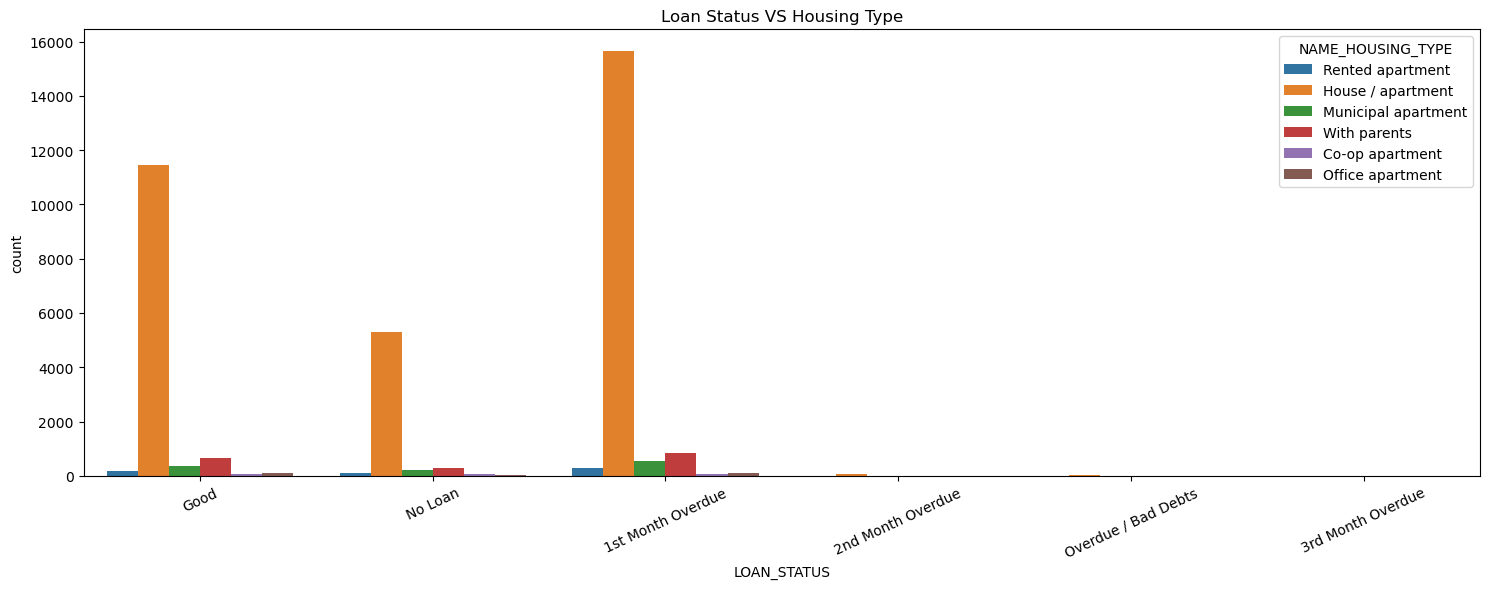

In [706]:
LoanStatus_HousingType = df.groupby('LOAN_STATUS')['NAME_HOUSING_TYPE'].value_counts().unstack()
print(LoanStatus_HousingType)

plt.figure(figsize=(15, 6))

sns.countplot(data = df, x = df['LOAN_STATUS'], hue = df['NAME_HOUSING_TYPE'] )
plt.title('Loan Status VS Housing Type')

plt.xticks(rotation = 25)

plt.tight_layout()
plt.show()

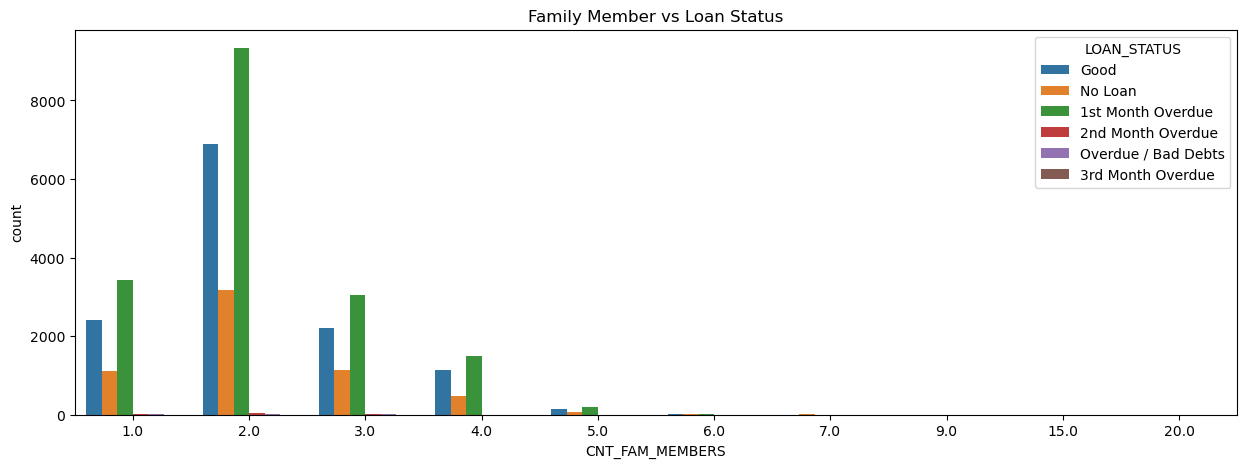

In [707]:
df.groupby('CNT_FAM_MEMBERS')[['LOAN_STATUS']].value_counts().unstack()

plt.figure(figsize=(15, 5))

# plotting the countplot
sns.countplot(data = df, x = df['CNT_FAM_MEMBERS'], hue = df['LOAN_STATUS'] )

#plt.xticks(rotation=25)
plt.title('Family Member vs Loan Status')

plt.show()

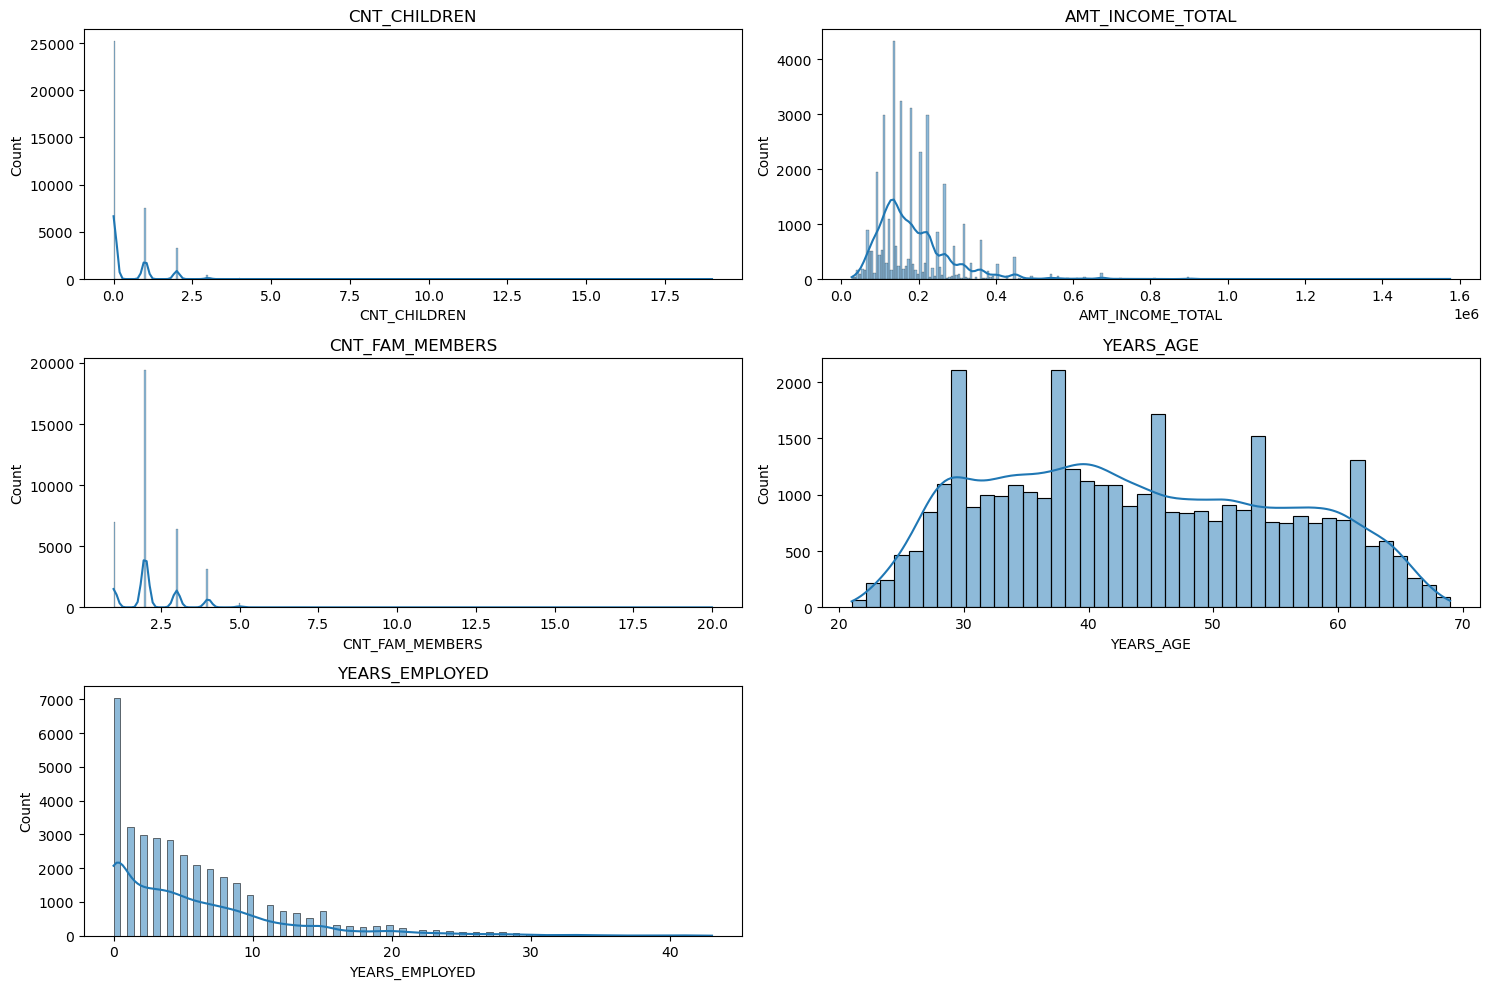

In [708]:
columns = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS','YEARS_AGE', 'YEARS_EMPLOYED']
plt.figure(figsize=(15, 10))

for i in range(len(columns)):
    plt.subplot(3, 2, i+1)
    plt.title(columns[i])
    
    #counts = df[columns[i]].value_counts()
    #colors = plt.cm.Paired(range(len(counts)))
    #plt.pie(counts, labels = counts.index, autopct = '%1.1f%%')
    #counts.plot(kind = "kde")
    
    sns.histplot(df[columns[i]], kde=True)
    #plt.legend(counts.index)
    
    #sns.countplot(data = df, x = df[columns[i]])
    #plt.xticks(rotation = 45)

plt.tight_layout()
#plt.show()


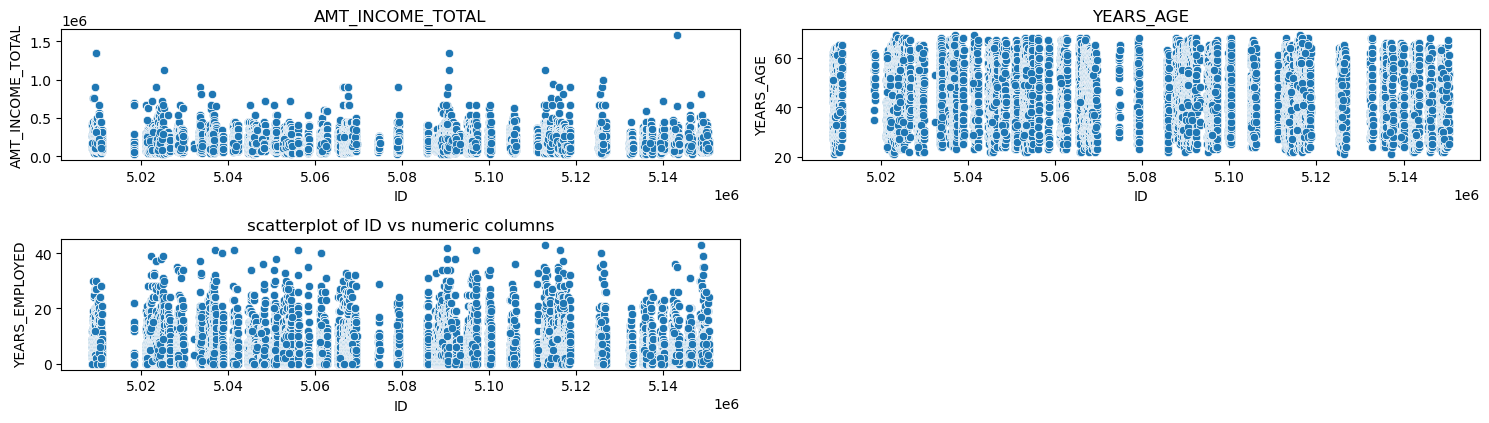

In [709]:
#sns.pairplot(df[['AMT_INCOME_TOTAL', 'YEARS_AGE', 'YEARS_EMPLOYED']])
#sns.scatterplot(df[['AMT_INCOME_TOTAL', 'YEARS_AGE', 'YEARS_EMPLOYED']])
#plt.suptitle('Pair Plot of Income, Age, and Employment Duration', y=1.02)
#plt.show()


col = ['AMT_INCOME_TOTAL', 'YEARS_AGE', 'YEARS_EMPLOYED']

# defining the figure size
plt.figure(figsize=(15, 6))

# plotting the countplot using for loop
for i in range(len(col)):
    plt.subplot(3, 2, i+1)
    plt.title(col[i])  # Use the column name as the title
    sns.scatterplot(data=df, y=col[i], x='ID')
plt.title('scatterplot of ID vs numeric columns')
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

Observation:
    


Observation:
    


Observations:
    


Observations:
    


Data Pre Processing

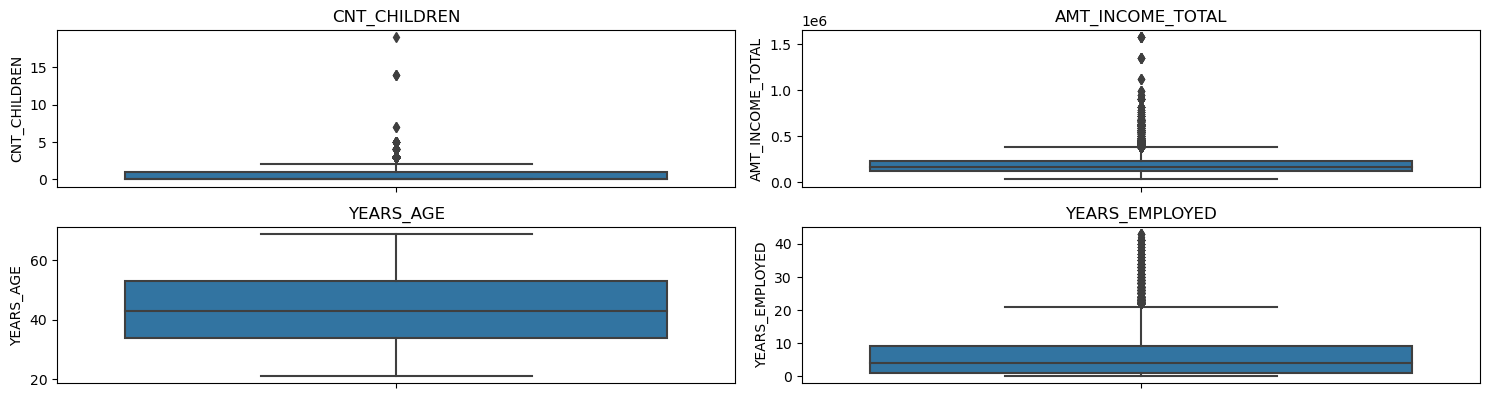

In [710]:
Columns = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'YEARS_AGE', 'YEARS_EMPLOYED']

plt.figure(figsize = (15, 6))

for i in range(len(Columns)):
    plt.subplot(3, 2, i+1)
    plt.title(Columns[i])
    sns.boxplot(data = df, y = Columns[i])


plt.tight_layout()
plt.show()

In [711]:
# removing outliers

# filtering the list of specific columns
col = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'YEARS_EMPLOYED']

# for loop to remove outliers
for i in range(len(col)):
    # calculating the first and third quartile
    q1 = df[col[i]].quantile(0.25)
    q3 = df[col[i]].quantile(0.75)
    # calculating the interquartile range
    iqr = q3 - q1
    # calculating the lower and upper bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # replacing the outliers with the median
    df[col[i]] = np.where((df[col[i]] >= upper_bound) | (df[col[i]] <= lower_bound), df[col[i]].median() , df[col[i]])

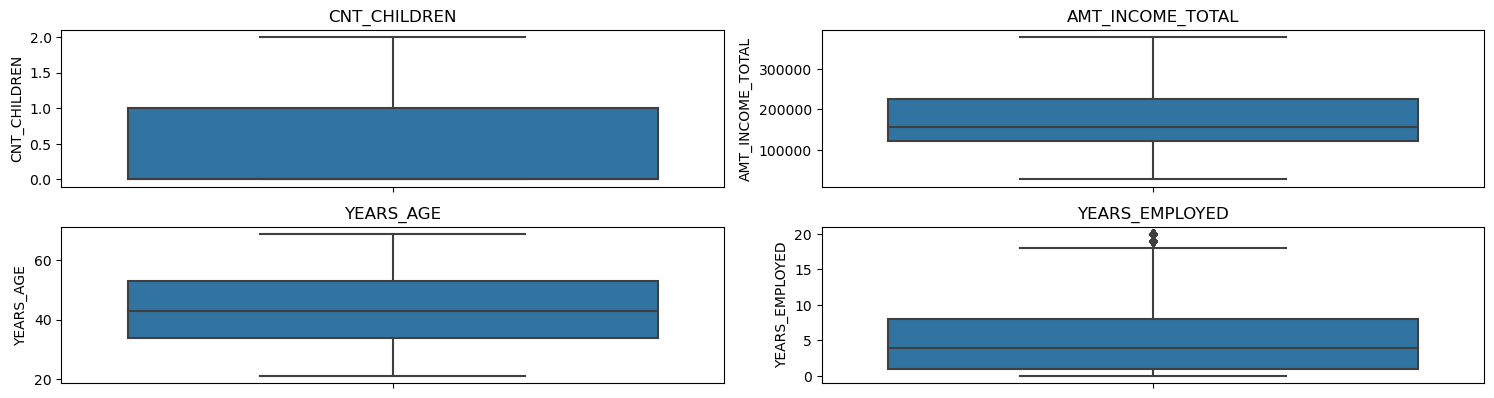

In [712]:
Columns = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'YEARS_AGE', 'YEARS_EMPLOYED']

plt.figure(figsize = (15, 6))

for i in range(len(Columns)):
    plt.subplot(3, 2, i+1)
    plt.title(Columns[i])
    sns.boxplot(data = df, y = Columns[i])


plt.tight_layout()
plt.show()

<Axes: >

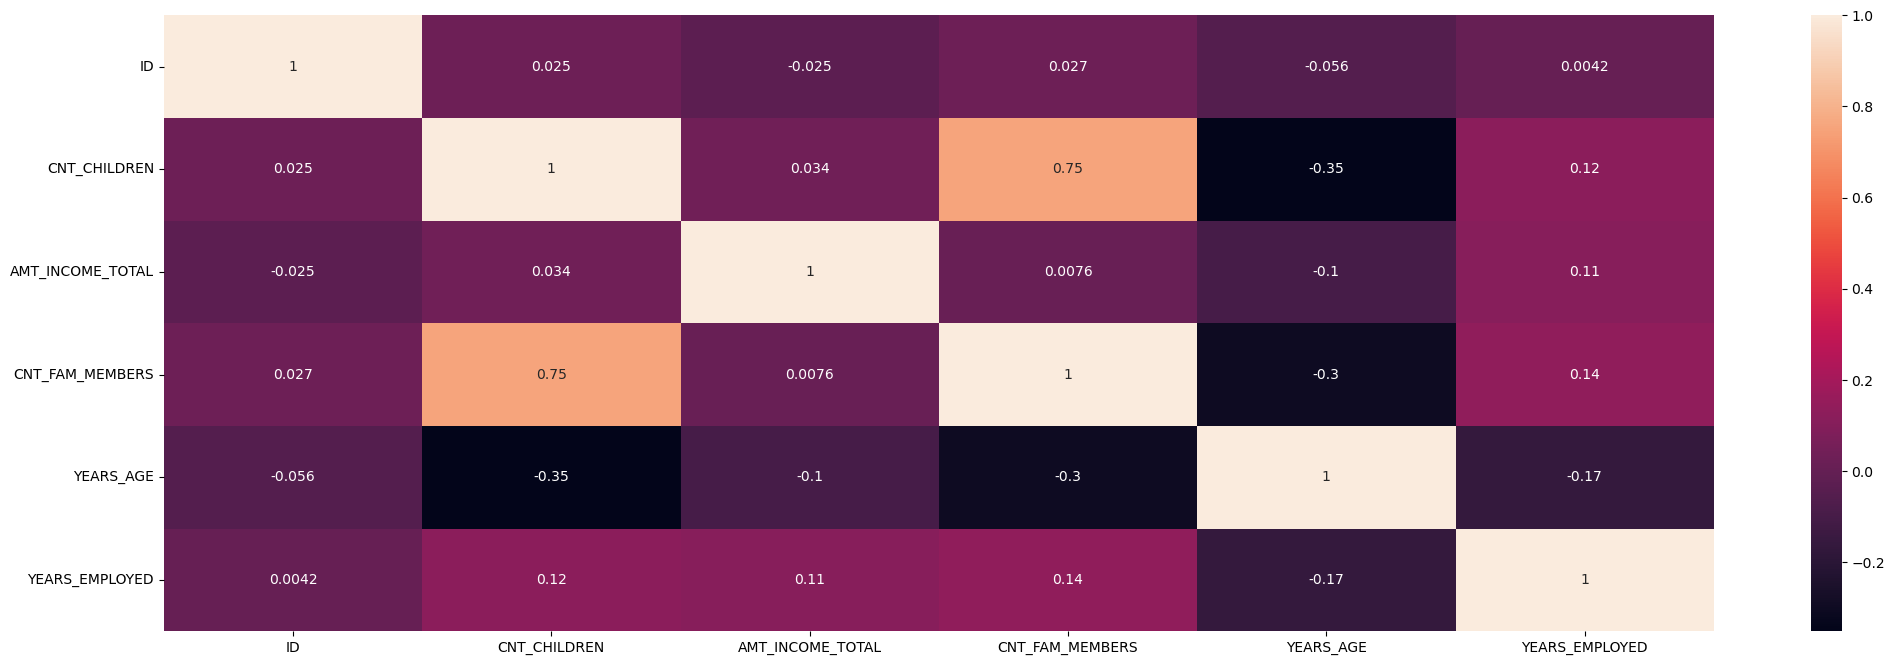

In [713]:
plt.figure(figsize=(25,8))
sns.heatmap(df.select_dtypes(exclude='object').corr(), annot = True)

### Observation

1. As we can see that children and family_members are highly correlated with each other
2. But there is no strong correlation between other numerical features
3. Hence, the condition of Independence of Observations is almost satisfied for Random Forest Classifier.

### Suitability of Model

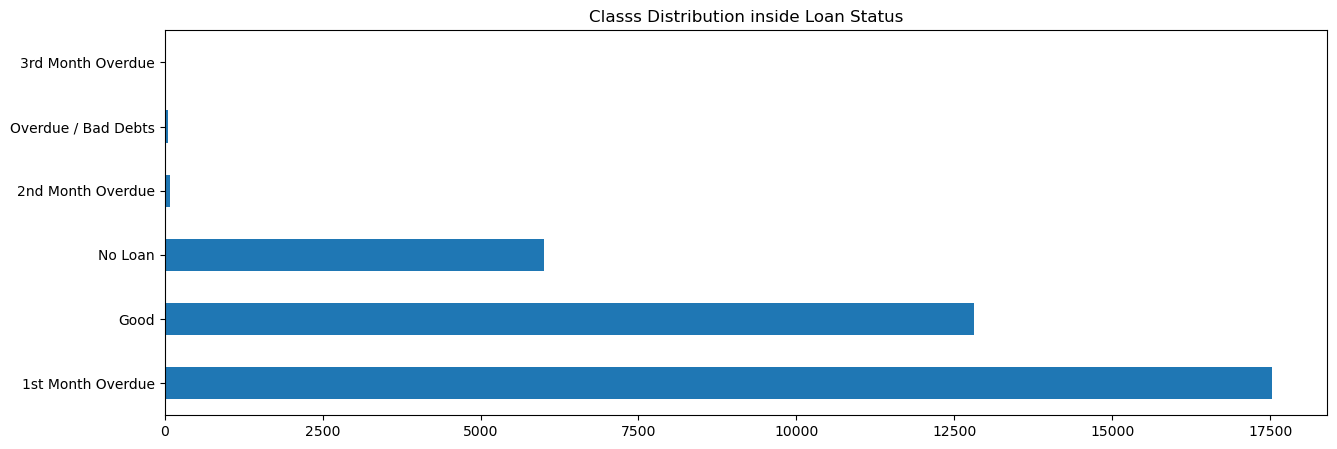

In [714]:
# checking the distribution of loan_status
df.LOAN_STATUS.value_counts().plot(kind='barh', figsize=(15, 5))
# defining the title
plt.title('Classs Distribution inside Loan Status')
plt.show()

### Observation:
    
1. The loan_status is our target variable.
2. If we see the class distribution, of our target variable loan_status, we can see that our target variable is highly imbalanced.
3. Which means that we cannot use logistic regression on our data.
4. That is why we need to use Random Forest Classifier for our model.

In [715]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   CNT_CHILDREN         36457 non-null  float64
 3   AMT_INCOME_TOTAL     36457 non-null  float64
 4   NAME_INCOME_TYPE     36457 non-null  object 
 5   NAME_EDUCATION_TYPE  36457 non-null  object 
 6   NAME_FAMILY_STATUS   36457 non-null  object 
 7   NAME_HOUSING_TYPE    36457 non-null  object 
 8   OCCUPATION_TYPE      25134 non-null  object 
 9   CNT_FAM_MEMBERS      36457 non-null  float64
 10  STATUS               36457 non-null  object 
 11  YEARS_AGE            36457 non-null  float64
 12  YEARS_EMPLOYED       36457 non-null  float64
 13  LOAN_STATUS          36457 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 4.2+ MB


In [720]:
df = pd.get_dummies(df, columns=[
    'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'
])

X = df.drop(['LOAN_STATUS' , 'STATUS'], axis = 1) # Assume that X is our independent variable

y = df['LOAN_STATUS'] # Assume that y is our dependent variable

# checking the column names of independent variable(X)
X.columns

Index(['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS',
       'YEARS_AGE', 'YEARS_EMPLOYED', 'CODE_GENDER_F', 'CODE_GENDER_M',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married',
       'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow',
       'NAME_HOUSING_TYPE_Co-op apartment',
       'NAME_HOUSING_TYPE_House / apartment',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Office apartment',
       'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_

In [721]:
print(f'The shpape of X ={X.shape} \n') # checking the shape of X

print(f'The shape of y ={y.shape}') # checking the shape of y

The shpape of X =(36457, 47) 

The shape of y =(36457,)


In [722]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Observation:

1. We have splitted the dataset into 80% train and 20% test
2. We have used Random Forest Classifier as our model
3. 80% of our dataset is used for training
4. 20% of our dataset is used for testing

In [723]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [733]:
# Handle class imbalance with SMOTE
# Adjust k_neighbors based on the distribution of the target variable
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=1)  # Adjust k_neighbors as needed
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [734]:
# Initialize Random Forest classifier
model = RandomForestClassifier(random_state=42)

In [735]:
# fitting the model
model.fit(X_train, y_train )

RandomForestClassifier(random_state=42)

In [736]:
# making predictions on the test set
y_pred = model.predict(X_test)

# creating a dataframe to compare the actual and predicted values
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(20)

,Actual,Predicted
21900,Good,Good
24293,Good,Good
19633,1st Month Overdue,1st Month Overdue
2496,1st Month Overdue,1st Month Overdue
25932,No Loan,Good
6267,1st Month Overdue,1st Month Overdue
6281,1st Month Overdue,No Loan
12287,1st Month Overdue,Good
14957,1st Month Overdue,Good
22040,Good,Good


In [741]:
#print(f'Accuracy Score : {accuracy_score(y_test, y_pred)*100:.2f} %')
#print(f"Precision Score : {precision_score(y_test, y_pred , average = 'micro'):.2f}")
#print(f"F1-Score : {f1_score(y_test, y_pred , average='micro')}")


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='micro')  # Adjust average as per your requirements
recall = recall_score(y_test, y_pred, average='micro')        # Adjust average as per your requirements
conf_matrix = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.5425123422929238
Precision: 0.5425123422929238
Recall: 0.5425123422929238
Confusion Matrix:
[[2186    5  913  358    1]
 [  11    2    5    1    0]
 [1015    4 1305  249    4]
 [ 420    1  342  461    2]
 [   3    0    2    0    2]]


In [742]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

  1st Month Overdue       0.60      0.63      0.62      3463
  2nd Month Overdue       0.17      0.11      0.13        19
               Good       0.51      0.51      0.51      2577
            No Loan       0.43      0.38      0.40      1226
Overdue / Bad Debts       0.22      0.29      0.25         7

           accuracy                           0.54      7292
          macro avg       0.39      0.38      0.38      7292
       weighted avg       0.54      0.54      0.54      7292

